<img src=./fig/fig1.png>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from tqdm import tqdm
import random

import time
import os

from pyvi import ViTokenizer
from transformers import AutoTokenizer

import warnings
warnings.filterwarnings('ignore')

/home/nhatlinh/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seeds():
    # fix random seeds
    SEED_VALUE = 2025
 
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
set_seeds()

### transformer encoder

In [3]:
class TransformerEncoder(nn.Module):
  def __init__(self, d_model, n_heads, mlp_ratio =4):
      super().__init__()

      self.d_model = d_model
      self.n_heads = n_heads

      self.ln1 = nn.LayerNorm(d_model)

      self.mha = MultiheadAttention(d_model, n_heads)

      self.ln2 = nn.LayerNorm(d_model)

      self.mlp = nn.Sequential(
          nn.Linear(d_model, d_model*mlp_ratio),
          nn.GELU(),
          nn.Linear(d_model * mlp_ratio, d_model)
      )

  def forward(self, x, mask = None):

      x_n = self.mha(self.ln1(x), mask = mask)
      x = x + self.mlp(self.ln2(x_n))

      return x  # [B,max_seq_len,d_model]

### multi head attention

In [4]:
class MultiheadAttention(nn.Module):
  def __init__(self, d_model, n_heads):
      super().__init__()

      self.qkv_dim = d_model //  n_heads 

      self.W_o = nn.Linear(d_model,d_model) 

      self.multi_head = nn.ModuleList([AttentionHead(d_model, self.qkv_dim) for _ in range(n_heads)])

  def forward(self,x,mask = None):

      out = torch.cat([head(x, mask=mask) for head in self.multi_head], dim = -1)

      out = self.W_o(out)

      return out

### attention head

In [5]:
class AttentionHead(nn.Module):
    def __init__(self, d_model, qkv_dim):
        super().__init__()

        self.qkv_dim = qkv_dim

        self.query = nn.Linear(d_model, qkv_dim)
        self.key = nn.Linear(d_model, qkv_dim)
        self.value = nn.Linear(d_model, qkv_dim)

    def forward(self, x, mask=None):

        Q = self.query(x)  
        K = self.key(x)      
        V = self.value(x)    

        if torch.isnan(Q).any() or torch.isnan(K).any() or torch.isnan(V).any():
            raise ValueError("NaN detected in Q, K, or V")
        if torch.isinf(Q).any() or torch.isinf(K).any() or torch.isinf(V).any():
            raise ValueError("Inf detected in Q, K, or V")

        attention = Q @ K.transpose(-2, -1)  # [B, max_seq_len, max_seq_len]
        
        # scaling
        if self.qkv_dim <= 0:
            raise ValueError("qkv_dim must be positive to avoid division by zero")
        attention = attention / self.qkv_dim ** 0.5  # [B, max_seq_len, max_seq_len]

        if torch.isnan(attention).any() or torch.isinf(attention).any():
            raise ValueError("NaN or Inf detected in attention scores")

        if mask is not None:
            # mask.shape: [B, max_seq_len]
            # expand mask to [B, max_seq_len, max_seq_len]
            mask = mask.unsqueeze(2)  # [B, max_seq_len, 1]
            mask = mask.expand(-1, -1, mask.size(1))  # [B, max_seq_len, max_seq_len]
            attention = attention.masked_fill(mask == 0, float("-inf"))

            all_inf = torch.all(attention == float("-inf"), dim=-1, keepdim=True)
            attention = attention.masked_fill(all_inf, 0.0)  

        attention = torch.softmax(attention, dim=-1)  # [B, max_seq_len, max_seq_len]

        if torch.isnan(attention).any():
            raise ValueError("NaN detected in attention weights after softmax")

        attention = attention @ V  # [B, max_seq_len, qkv_dim]

        if torch.isnan(attention).any() or torch.isinf(attention).any():
            raise ValueError("NaN or Inf detected in final attention output")

        return attention

### positional embedding

In [6]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        self.d_model = d_model
        self.max_seq_length = max_seq_length

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len]

### vision encoder

<img src=./fig/fig3.png>

In [7]:
class VisionEncoder(nn.Module):

    def __init__(self, d_model,img_size,patch_size, n_channels, n_heads,n_layers, emb_dim):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] ==0, "image dimensions should be divisible by patch dim"
        assert d_model % n_heads == 0, "d_model should be divisible by n_heads"

        self.num_patches = (img_size[0] * img_size[1] ) // (patch_size[0] * patch_size[1]) 

        self.max_seq_length = self.num_patches +1

        self.linear_proj = nn.Conv2d(in_channels = n_channels,out_channels = d_model, kernel_size = patch_size[0], stride = patch_size[0])

        self.cls_token = nn.Parameter(torch.randn(1,1,d_model), requires_grad = True)

        self.positional_embedding =  PositionalEmbedding(d_model, self.max_seq_length)

        self.transformer_encoder = nn.ModuleList([TransformerEncoder(d_model, n_heads) for _ in range(n_layers)])

        self.projection = nn.Parameter(torch.randn(d_model, emb_dim))

    def forward(self,x, mask = None):
       
        x  = self.linear_proj(x)  

        x = x.flatten(2).transpose(-2, -1)   
        
        x = torch.cat((self.cls_token.expand(x.shape[0], -1,-1), x), dim = 1) 

        x =  self.positional_embedding(x)  #  [B,max_seq_len,d_model]

        for encoder_layer in self.transformer_encoder:
            x = encoder_layer(x, mask)  #  [B, d_model]

        x = x[:, 0, :] 

        if self.projection is not None:
           x  = x  @ self.projection  #[B, emb_dim]

        x  = x  / torch.norm(x , dim = -1 , keepdim = True) 


        return x

### tokenizer

In [8]:
# PhoBERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

def tokenize_vietnamese_text(text, max_seq_length=128):

    try:
        segmented_text = ViTokenizer.tokenize(text)
    except Exception as e:
        print(f"Error during word segmentation: {e}")
        raise

    encoding = tokenizer(
        segmented_text,
        add_special_tokens=True,
        max_length=max_seq_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].squeeze(0)
    attention_mask = encoding['attention_mask'].squeeze(0)

    return input_ids, attention_mask

### text encoder

<img src=./fig/fig2.png>

In [9]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size=64000, d_model=64, max_seq_length=128, n_layers=8, n_heads=8, emb_dim=128):
        super().__init__()

        self.max_seq_length = max_seq_length

        self.embed = nn.Embedding(vocab_size, d_model)

        self.positional_embedding = PositionalEmbedding(d_model, max_seq_length)

        self.transformer_encoder = nn.ModuleList([TransformerEncoder(d_model, n_heads) for _ in range(n_layers)])

        self.projection = nn.Parameter(torch.randn(d_model, emb_dim))

    def forward(self, text, mask=None):
        x = self.embed(text)  # [B, max_seq_length]

        x = self.positional_embedding(x)  # [B, max_seq_length, d_model]

        for encoder_layer in self.transformer_encoder:
            x = encoder_layer(x, mask=mask)  # [B, max_seq_length, d_model]

        x = x[:, 0]  # [B, d_model]

        if self.projection is not None:
            x = x @ self.projection  # [B, emb_dim]

        x = x / torch.norm(x, dim=-1, keepdim=True)  

        return x

In [10]:
class TextEncoder_Retrieval(nn.Module):
    def __init__(self, vocab_size=64000, d_model=64, max_seq_length=128, n_layers=8, n_heads=8, emb_dim=128):
        super().__init__()

        self.max_seq_length = max_seq_length

        self.embed = nn.Embedding(vocab_size, d_model)

        self.positional_embedding = PositionalEmbedding(d_model, max_seq_length)

        self.transformer_encoder = nn.ModuleList([TransformerEncoder(d_model, n_heads) for _ in range(n_layers)])

        self.projection = nn.Parameter(torch.randn(d_model, emb_dim))

    def forward(self, text, mask=None):
        x = self.embed(text)  # [B, max_seq_length]

        x = self.positional_embedding(x)  # [B, max_seq_length, d_model]

        for encoder_layer in self.transformer_encoder:
            x = encoder_layer(x, mask=mask)  # [B, max_seq_length, d_model]

        x = x[:, 0]  # [B, d_model]

        if self.projection is not None:
            x = x @ self.projection  # [B, emb_dim]

        x = x / torch.norm(x, dim=-1, keepdim=True)  

        return x

### custom model

In [11]:
class CustomModel(nn.Module):
    def __init__(self, emb_dim, vit_layers, vit_d_model, img_size, patch_size, n_channels, vit_heads, vocab_size, max_seq_length, text_heads, text_layers, text_d_model, retrieval=False):
        super().__init__()

        self.vision_encoder = VisionEncoder(vit_d_model, img_size, patch_size, n_channels, vit_heads, vit_layers, emb_dim)
        if retrieval:
            self.text_encoder = TextEncoder_Retrieval(vocab_size, text_d_model, max_seq_length, text_layers, text_heads, emb_dim)
        else:
            self.text_encoder = TextEncoder(vocab_size, text_d_model, max_seq_length, text_layers, text_heads, emb_dim)

        self.temperature = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def loss(self, logits, device="cuda"):
        labels = torch.arange(logits.shape[0]).to(device)
        loss_v = nn.functional.cross_entropy(logits.transpose(-2, -1), labels)
        loss_t = nn.functional.cross_entropy(logits, labels)
        loss = (loss_v + loss_t) / 2
        return loss

    def forward(self, image, text, mask=None):
        V_e = self.vision_encoder(image)  # [B, emb_dim]
        T_e = self.text_encoder(text, mask)  # [B, emb_dim]

        logits = (V_e @ T_e.transpose(-2, -1)) * torch.exp(self.temperature)
        loss = self.loss(logits, self.device)
        return loss

In [12]:
# vision
emb_dim = 1024 
vit_d_model = 64 #   vit_heads * vit_layers = vit_d_model
img_size = (80,80)
patch_size = (5,5) 
n_channels = 3
vit_layers = 8
vit_heads = 8 

# text
vocab_size = 64000
text_d_model = 16 #   text_heads * text_layers = text_d_model
max_seq_length = 128
text_heads = 4
text_layers = 4
lr = 1e-3
epochs = 50
batch_size = 256

### data collection

<img src=./fig/fig4.png>


### train dataset

In [13]:
df = pd.read_csv('data/train.csv', usecols=['id', 'label'])

print("Preprocessing product names...")
input_ids_list = []
attention_mask_list = []
for name in df['label']:
    input_ids, attention_mask = tokenize_vietnamese_text(name, max_seq_length=max_seq_length)
    input_ids_list.append(input_ids)
    attention_mask_list.append(attention_mask)

df['input_ids'] = input_ids_list
df['attention_mask'] = attention_mask_list

image_extensions = ['png', 'jpg', 'jpeg', 'PNG', 'JPG', 'JPEG']

valid_rows = []
missing_images = 0
for idx, row in df.iterrows():
    base_path = os.path.join("data/images", f"{row['id']}")
    found = False
    for ext in image_extensions:
        img_path = f"{base_path}.{ext}"
        if os.path.exists(img_path):
            found = True
            break
    if found:
        valid_rows.append(row)
    else:
        missing_images += 1
        missing_paths = ", ".join([f"{base_path}.{ext}" for ext in image_extensions])
        print(f"Missing image for id {row['id']}: none of [{missing_paths}] exist")

if not valid_rows:
    raise FileNotFoundError("No valid images found in the dataset.")

train_df = pd.DataFrame(valid_rows)
print(f"Total train samples after filtering: {len(df)} (Removed {missing_images} samples with missing images)")

Preprocessing product names...


Missing image for id 273685774: none of [data/images/273685774.png, data/images/273685774.jpg, data/images/273685774.jpeg, data/images/273685774.PNG, data/images/273685774.JPG, data/images/273685774.JPEG] exist
Missing image for id 126689903: none of [data/images/126689903.png, data/images/126689903.jpg, data/images/126689903.jpeg, data/images/126689903.PNG, data/images/126689903.JPG, data/images/126689903.JPEG] exist
Missing image for id 74347298: none of [data/images/74347298.png, data/images/74347298.jpg, data/images/74347298.jpeg, data/images/74347298.PNG, data/images/74347298.JPG, data/images/74347298.JPEG] exist
Missing image for id 196788353: none of [data/images/196788353.png, data/images/196788353.jpg, data/images/196788353.jpeg, data/images/196788353.PNG, data/images/196788353.JPG, data/images/196788353.JPEG] exist
Missing image for id 277478409: none of [data/images/277478409.png, data/images/277478409.jpg, data/images/277478409.jpeg, data/images/277478409.PNG, data/images/2

### test dataset

In [14]:
print("Loading and preprocessing test data...")
test_df = pd.read_csv('data/test.csv', usecols=['id', 'label'])

print("Preprocessing product names for test data...")
test_input_ids_list = []
test_attention_mask_list = []
for name in test_df['label']:
    input_ids, attention_mask = tokenize_vietnamese_text(name, max_seq_length=max_seq_length)
    test_input_ids_list.append(input_ids)
    test_attention_mask_list.append(attention_mask)

test_df['input_ids'] = test_input_ids_list
test_df['attention_mask'] = test_attention_mask_list

test_valid_rows = []
test_missing_images = 0
for idx, row in test_df.iterrows():
    base_path = os.path.join("data/images", f"{row['id']}")
    found = False
    for ext in image_extensions:
        img_path = f"{base_path}.{ext}"
        if os.path.exists(img_path):
            found = True
            break
    if found:
        test_valid_rows.append(row)
    else:
        test_missing_images += 1
        missing_paths = ", ".join([f"{base_path}.{ext}" for ext in image_extensions])
        print(f"Missing image for id {row['id']} in test data: none of [{missing_paths}] exist")

if not test_valid_rows:
    raise FileNotFoundError("No valid images found in the test dataset.")

test_df = pd.DataFrame(test_valid_rows)
print(f"Total test samples after filtering: {len(test_df)} (Removed {test_missing_images} samples with missing images)")

Loading and preprocessing test data...
Preprocessing product names for test data...


Total test samples after filtering: 4374 (Removed 0 samples with missing images)


In [15]:
print(f"Final dataset sizes: Train={len(train_df)}, Test={len(test_df)}")

Final dataset sizes: Train=10126, Test=4374


In [16]:
# check number of cpu cores for num_workers in dataloader
torch.multiprocessing.cpu_count()

72

In [17]:
class CustomDataset(Dataset):
    def __init__(self, data_frame, target_size=80):
        self.data_frame = data_frame
        self.target_size = target_size
        self.transform = T.Compose([
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        max_retries = 10  
        retries = 0
        original_idx = idx  

        image_extensions = ['png', 'jpg', 'jpeg', 'PNG', 'JPG', 'JPEG']

        while retries < max_retries:
            sample = self.data_frame.iloc[idx]
            base_path = os.path.join("./data/images", f"{sample['id']}")

            image = None
            img_path = None
            for ext in image_extensions:
                try_path = f"{base_path}.{ext}"
                try:
                    image = Image.open(try_path).convert('RGB')
                    img_path = try_path
                    break  
                except (FileNotFoundError, IOError):
                    continue  

            if image is None:
                missing_paths = ", ".join([f"{base_path}.{ext}" for ext in image_extensions])
                print(f"Error loading image for id {sample['id']}: none of [{missing_paths}] exist")
                idx = (idx + 1) % len(self.data_frame)
                retries += 1
                if idx == original_idx and retries > 0:
                    raise FileNotFoundError("No valid images found after trying all samples in the dataset.")
                continue

            image = self.resize_and_pad(image, self.target_size)
            image = self.transform(image)

            name = sample['label']
            try:
                input_ids, mask = tokenize_vietnamese_text(name, max_seq_length=128)
            except Exception as e:
                print(f"Error tokenizing name '{name}' at index {idx}: {e}")
                idx = (idx + 1) % len(self.data_frame)
                retries += 1
                if idx == original_idx:
                    raise RuntimeError("No valid samples found after trying all samples in the dataset.")
                continue


            return {"image": image, "caption": input_ids, "mask": mask, "id": img_path}

        raise RuntimeError(f"Failed to find a valid sample after {max_retries} retries.")

    def resize_and_pad(self, image, target_size):
        original_width, original_height = image.size
        aspect_ratio = original_width / original_height

        if aspect_ratio > 1:
            new_width = target_size
            new_height = int(target_size / aspect_ratio)
        else:
            new_height = target_size
            new_width = int(target_size * aspect_ratio)

        image = image.resize((new_width, new_height))

        pad_width = (target_size - new_width) // 2
        pad_height = (target_size - new_height) // 2

        padding = (pad_width, pad_height, target_size - new_width - pad_width, target_size - new_height - pad_height)
        image = ImageOps.expand(image, padding, fill=(0, 0, 0))

        return image

train_dataset = CustomDataset(data_frame=train_df, target_size=80)
test_dataset = CustomDataset(data_frame=test_df, target_size=80)

print("Number of Samples in Train Dataset:", len(train_dataset))
print("Number of Samples in Test Dataset:", len(test_dataset))


train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=72)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=72)

len(next(iter(train_loader)))

Number of Samples in Train Dataset: 10126
Number of Samples in Test Dataset: 4374


4

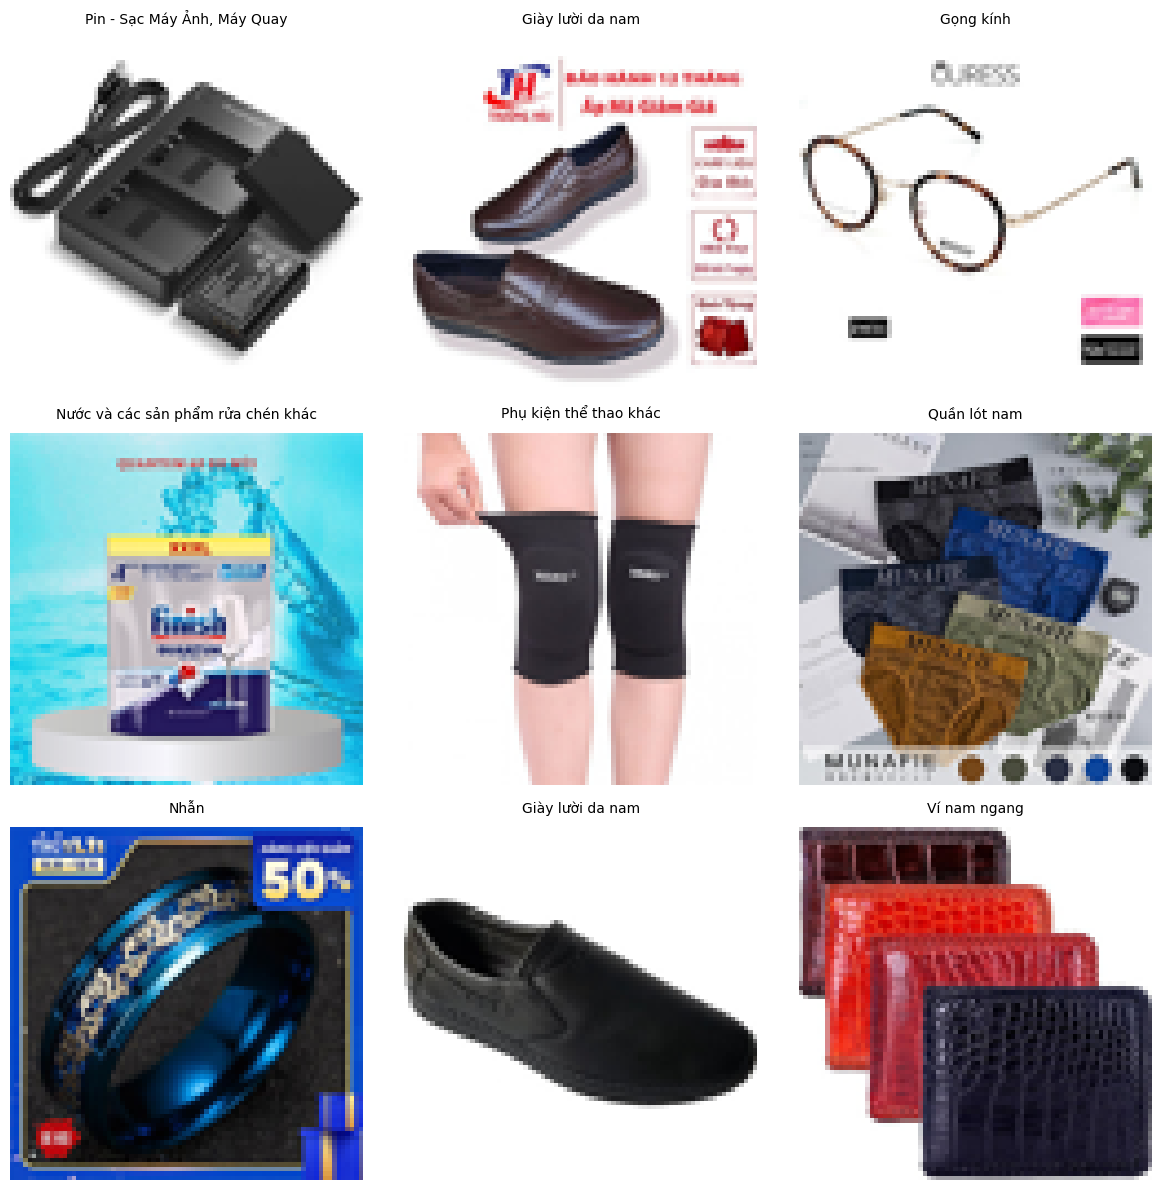

In [25]:
def visualize_samples(dataset, num_samples=9, grid_cols=3):
    indices = random.sample(range(len(dataset)), num_samples)
    
    grid_rows = (num_samples + grid_cols - 1) // grid_cols
    
    plt.figure(figsize=(grid_cols * 4, grid_rows * 4))
    
    for idx, sample_idx in enumerate(indices):
        sample = dataset[sample_idx]
        image = sample['image']
        name = dataset.data_frame.iloc[sample_idx]['label'] 
        
        image = T.ToPILImage()(image)
        
        plt.subplot(grid_rows, grid_cols, idx + 1)
        plt.imshow(image, interpolation='nearest')
        plt.title(f"{name}", fontsize=10, pad=10)  
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset, num_samples=9, grid_cols=3)

### Training

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")


model = CustomModel(emb_dim, vit_layers, vit_d_model, img_size,patch_size,n_channels, vit_heads, vocab_size, max_seq_length, text_heads, text_layers,text_d_model, retrieval = False).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)

Using device:  cuda (NVIDIA GeForce RTX 3080 Ti)


In [20]:
total_params = 0

total_params = sum([ param.numel() for param in model.parameters() if param.requires_grad])

print(f"Total number of trainable parameters: {total_params/1000000:.2f} M")

Total number of trainable parameters: 1.52 M


In [21]:
log_file = "training_log.txt"

with open(log_file, "w") as f:
    f.write("Training Log\n")
    f.write("=" * 20 + "\n")

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

with open(log_file, "a") as f:
    f.write(f"Number of parameters: {num_params:,}\n")
    f.write("=" * 20 + "\n")

start_time = time.time()

best_loss = np.inf
for epoch in range(epochs):
    epoch_loss = 0.0  
    with tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch [{epoch+1}/{epochs}]") as tepoch:
        for i, data in tepoch:
            img, cap, mask = data["image"].to(device), data["caption"].to(device), data["mask"].to(device)
            optimizer.zero_grad()
            loss = model(img, cap, mask)
            loss.backward()
            optimizer.step()

            tepoch.set_postfix(loss=loss.item())
            epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.3f}")

    with open(log_file, "a") as f:
        f.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.3f}\n")

    if avg_loss <= best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "e-com.pt")
        print("Model Saved.")

        model_size = os.path.getsize("e-com.pt") / (1024 * 1024)  
        with open(log_file, "a") as f:
            f.write(f"Model Saved at Epoch {epoch+1}\n")
            f.write(f"Model Size: {model_size:.2f} MB\n")

end_time = time.time()
total_time = end_time - start_time
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)

with open(log_file, "a") as f:
    f.write("=" * 20 + "\n")
    f.write(f"Total Training Time: {int(hours)}h {int(minutes)}m {seconds:.2f}s\n")
    f.write(f"Best Loss: {best_loss:.3f}\n")

print(f"Training completed. Log saved to {log_file}")

Epoch [1/50]: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s, loss=4.96]

Epoch [1/50], Average Loss: 5.531
Model Saved.



Epoch [2/50]: 100%|██████████| 40/40 [00:16<00:00,  2.47it/s, loss=4.95]

Epoch [2/50], Average Loss: 5.530
Model Saved.



Epoch [3/50]: 100%|██████████| 40/40 [00:16<00:00,  2.47it/s, loss=4.87]

Epoch [3/50], Average Loss: 5.495
Model Saved.



Epoch [4/50]: 100%|██████████| 40/40 [00:16<00:00,  2.43it/s, loss=4.66]

Epoch [4/50], Average Loss: 5.343
Model Saved.



Epoch [5/50]: 100%|██████████| 40/40 [00:16<00:00,  2.46it/s, loss=4.5] 

Epoch [5/50], Average Loss: 5.176
Model Saved.



Epoch [6/50]: 100%|██████████| 40/40 [00:16<00:00,  2.46it/s, loss=4.38]

Epoch [6/50], Average Loss: 5.045
Model Saved.



Epoch [7/50]: 100%|██████████| 40/40 [00:16<00:00,  2.41it/s, loss=4.29]

Epoch [7/50], Average Loss: 4.934
Model Saved.



Epoch [8/50]: 100%|██████████| 40/40 [00:16<00:00,  2.43it/s, loss=4.1] 

Epoch [8/50], Average Loss: 4.819
Model Saved.



Epoch [9/50]: 100%|██████████| 40/40 [00:16<00:00,  2.47it/s, loss=4.25]

Epoch [9/50], Average Loss: 4.727
Model Saved.



Epoch [10/50]: 100%|██████████| 40/40 [00:16<00:00,  2.43it/s, loss=4.15]

Epoch [10/50], Average Loss: 4.624
Model Saved.



Epoch [11/50]: 100%|██████████| 40/40 [00:16<00:00,  2.44it/s, loss=3.91]

Epoch [11/50], Average Loss: 4.549
Model Saved.



Epoch [12/50]: 100%|██████████| 40/40 [00:16<00:00,  2.43it/s, loss=4.05]

Epoch [12/50], Average Loss: 4.456
Model Saved.



Epoch [13/50]: 100%|██████████| 40/40 [00:16<00:00,  2.45it/s, loss=3.68]

Epoch [13/50], Average Loss: 4.372
Model Saved.



Epoch [14/50]: 100%|██████████| 40/40 [00:16<00:00,  2.44it/s, loss=3.68]

Epoch [14/50], Average Loss: 4.318
Model Saved.



Epoch [15/50]: 100%|██████████| 40/40 [00:16<00:00,  2.43it/s, loss=3.5] 

Epoch [15/50], Average Loss: 4.233
Model Saved.



Epoch [16/50]: 100%|██████████| 40/40 [00:19<00:00,  2.08it/s, loss=3.69]

Epoch [16/50], Average Loss: 4.168
Model Saved.



Epoch [17/50]: 100%|██████████| 40/40 [00:16<00:00,  2.44it/s, loss=3.69]

Epoch [17/50], Average Loss: 4.099
Model Saved.



Epoch [18/50]: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s, loss=3.45]

Epoch [18/50], Average Loss: 4.017
Model Saved.



Epoch [19/50]: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s, loss=3.35]

Epoch [19/50], Average Loss: 3.942
Model Saved.



Epoch [20/50]: 100%|██████████| 40/40 [00:17<00:00,  2.35it/s, loss=3.54]

Epoch [20/50], Average Loss: 3.866
Model Saved.



Epoch [21/50]: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s, loss=3.32]

Epoch [21/50], Average Loss: 3.801
Model Saved.



Epoch [22/50]: 100%|██████████| 40/40 [00:16<00:00,  2.42it/s, loss=3.48]

Epoch [22/50], Average Loss: 3.748
Model Saved.



Epoch [23/50]: 100%|██████████| 40/40 [00:16<00:00,  2.44it/s, loss=3.1] 

Epoch [23/50], Average Loss: 3.679
Model Saved.



Epoch [24/50]: 100%|██████████| 40/40 [00:16<00:00,  2.47it/s, loss=3.09]

Epoch [24/50], Average Loss: 3.609
Model Saved.



Epoch [25/50]: 100%|██████████| 40/40 [00:16<00:00,  2.41it/s, loss=3.35]

Epoch [25/50], Average Loss: 3.517
Model Saved.



Epoch [26/50]: 100%|██████████| 40/40 [00:16<00:00,  2.45it/s, loss=3]   

Epoch [26/50], Average Loss: 3.424
Model Saved.



Epoch [27/50]: 100%|██████████| 40/40 [00:16<00:00,  2.42it/s, loss=2.73]

Epoch [27/50], Average Loss: 3.360
Model Saved.



Epoch [28/50]: 100%|██████████| 40/40 [00:16<00:00,  2.45it/s, loss=2.89]

Epoch [28/50], Average Loss: 3.299
Model Saved.



Epoch [29/50]: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s, loss=2.65]

Epoch [29/50], Average Loss: 3.212
Model Saved.



Epoch [30/50]: 100%|██████████| 40/40 [00:16<00:00,  2.45it/s, loss=2.76]

Epoch [30/50], Average Loss: 3.169
Model Saved.



Epoch [31/50]: 100%|██████████| 40/40 [00:16<00:00,  2.45it/s, loss=2.61]

Epoch [31/50], Average Loss: 3.076
Model Saved.



Epoch [32/50]: 100%|██████████| 40/40 [00:16<00:00,  2.41it/s, loss=2.54]

Epoch [32/50], Average Loss: 3.037
Model Saved.



Epoch [33/50]: 100%|██████████| 40/40 [00:16<00:00,  2.41it/s, loss=2.49]

Epoch [33/50], Average Loss: 2.943
Model Saved.



Epoch [34/50]: 100%|██████████| 40/40 [00:16<00:00,  2.37it/s, loss=2.35]

Epoch [34/50], Average Loss: 2.889
Model Saved.



Epoch [35/50]: 100%|██████████| 40/40 [00:16<00:00,  2.42it/s, loss=2.29]

Epoch [35/50], Average Loss: 2.742
Model Saved.



Epoch [36/50]: 100%|██████████| 40/40 [00:16<00:00,  2.43it/s, loss=2.22]

Epoch [36/50], Average Loss: 2.721
Model Saved.



Epoch [37/50]: 100%|██████████| 40/40 [00:16<00:00,  2.44it/s, loss=2.28]

Epoch [37/50], Average Loss: 2.700
Model Saved.



Epoch [38/50]: 100%|██████████| 40/40 [00:16<00:00,  2.42it/s, loss=2.09]

Epoch [38/50], Average Loss: 2.630
Model Saved.



Epoch [39/50]: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s, loss=2.04]

Epoch [39/50], Average Loss: 2.499
Model Saved.



Epoch [40/50]: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s, loss=1.93]

Epoch [40/50], Average Loss: 2.450
Model Saved.



Epoch [41/50]: 100%|██████████| 40/40 [00:16<00:00,  2.41it/s, loss=1.92]

Epoch [41/50], Average Loss: 2.455



Epoch [42/50]: 100%|██████████| 40/40 [00:16<00:00,  2.45it/s, loss=2]   

Epoch [42/50], Average Loss: 2.422
Model Saved.



Epoch [43/50]: 100%|██████████| 40/40 [00:16<00:00,  2.42it/s, loss=2.01]

Epoch [43/50], Average Loss: 2.420
Model Saved.



Epoch [44/50]: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s, loss=1.95]

Epoch [44/50], Average Loss: 2.379
Model Saved.



Epoch [45/50]: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s, loss=1.84]

Epoch [45/50], Average Loss: 2.321
Model Saved.



Epoch [46/50]: 100%|██████████| 40/40 [00:16<00:00,  2.42it/s, loss=1.76]

Epoch [46/50], Average Loss: 2.318
Model Saved.



Epoch [47/50]: 100%|██████████| 40/40 [00:16<00:00,  2.41it/s, loss=1.91]

Epoch [47/50], Average Loss: 2.253
Model Saved.



Epoch [48/50]: 100%|██████████| 40/40 [00:16<00:00,  2.41it/s, loss=1.63]

Epoch [48/50], Average Loss: 2.272



Epoch [49/50]: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s, loss=1.65]

Epoch [49/50], Average Loss: 2.245
Model Saved.



Epoch [50/50]: 100%|██████████| 40/40 [00:16<00:00,  2.44it/s, loss=1.65]

Epoch [50/50], Average Loss: 2.183
Model Saved.
Training completed. Log saved to training_log.txt


### Evaluation

In [22]:
import torch
import time

model = CustomModel(emb_dim, vit_layers, vit_d_model, img_size, patch_size, n_channels, vit_heads, vocab_size, max_seq_length, text_heads, text_layers, text_d_model, retrieval=False).to(device)
model.load_state_dict(torch.load("e-com.pt", map_location=device))

text_inputs = torch.stack([sample['caption'] for sample in test_dataset]).to(device)
text_masks = torch.stack([sample['mask'] for sample in test_dataset]).to(device)

def time_gpu_inference(model, inputs, encoder_type, mask=None):
    model.eval()
    torch.cuda.synchronize()
    start_time = time.time()
    with torch.no_grad():
        if encoder_type == 'text':
            features = model.text_encoder(inputs, mask=mask)
        else:  # vision
            features = model.vision_encoder(inputs)
    torch.cuda.synchronize()
    end_time = time.time()
    return (end_time - start_time) * 1000  # convert to milliseconds


with torch.no_grad():
    text_features = model.text_encoder(text_inputs, mask=text_masks)
    text_features /= text_features.norm(dim=-1, keepdim=True)

image_features_all = []
image_indices = []
total = 0
with torch.no_grad():
    for data in test_loader:
        images = data["image"].to(device)
        batch_size = images.shape[0]
        batch_indices = torch.arange(total, total + batch_size).to(device)
        image_features = model.vision_encoder(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        image_features_all.append(image_features)
        image_indices.append(batch_indices)
        total += batch_size
image_features_all = torch.cat(image_features_all, dim=0)
image_indices = torch.cat(image_indices, dim=0)

k_values = [1, 5, 10]
cosine_similarities_t2i = {k: 0 for k in k_values}
cosine_similarities_i2i = {k: 0 for k in k_values}
total = 0

with torch.no_grad():
    for data in test_loader:
        images = data["image"].to(device)
        batch_size = images.shape[0]
        batch_indices = torch.arange(total, total + batch_size).to(device)

        # Compute image features
        image_features = model.vision_encoder(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Text-to-image retrieval
        similarity_t2i = text_features[batch_indices] @ image_features_all.T
        _, top_k_indices_t2i = similarity_t2i.topk(max(k_values), dim=1)

        # Image-to-image retrieval
        similarity_i2i = image_features @ image_features_all.T
        # Exclude self-matches
        similarity_i2i[torch.arange(batch_size, device=device), batch_indices] = float('-inf')
        _, top_k_indices_i2i = similarity_i2i.topk(max(k_values), dim=1)

        for k in k_values:
            top_k_similarities_t2i = similarity_t2i.gather(1, top_k_indices_t2i[:, :k])
            cosine_similarities_t2i[k] += top_k_similarities_t2i.mean().item() * batch_size

        for k in k_values:
            top_k_similarities_i2i = similarity_i2i.gather(1, top_k_indices_i2i[:, :k])
            cosine_similarities_i2i[k] += top_k_similarities_i2i.mean().item() * batch_size

        total += batch_size

# 1. text encoder inference
text_inputs_gpu = text_inputs.to(device)
text_masks_gpu = text_masks.to(device)
model.to(device)
gpu_text_time = time_gpu_inference(model, text_inputs_gpu, 'text', mask=text_masks_gpu)

# 2. vision encoder inference
for data in test_loader:
    images = data["image"].to(device)
    gpu_vision_time = time_gpu_inference(model, images, 'vision')
    break  


print("\nText-to-Image Metrics:")
for k in k_values:
    mean_cosine_t2i = cosine_similarities_t2i[k] / total
    print(f'Mean Cosine Similarity@Top-{k}: {mean_cosine_t2i:.4f}')

print("\nImage-to-Image Metrics:")
for k in k_values:
    mean_cosine_i2i = cosine_similarities_i2i[k] / total
    print(f'Mean Cosine Similarity@Top-{k}: {mean_cosine_i2i:.4f}')

print("\nInference Times (milliseconds):")
print(f"Text Encoder: {gpu_text_time:.2f} ms")
print(f"Vision Encoder: {gpu_vision_time:.2f} ms")


Text-to-Image Metrics:
Mean Cosine Similarity@Top-1: 0.3812
Mean Cosine Similarity@Top-5: 0.3690
Mean Cosine Similarity@Top-10: 0.3615

Image-to-Image Metrics:
Mean Cosine Similarity@Top-1: 0.8158
Mean Cosine Similarity@Top-5: 0.7743
Mean Cosine Similarity@Top-10: 0.7504

Inference Times (milliseconds):
Text Encoder: 188.02 ms
Vision Encoder: 172.73 ms
